In [1]:
import sys
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as ppt
%matplotlib inline

PROGRESS_DATA_PATH = '/media/sf_Masterarbeit/data/AE_PROGRESS/imagenet_0.9c_100iter_800samples_data.npy'
#PROGRESS_DATA_PATH = '/media/sf_Masterarbeit/data/AE_PROGRESS/' +\
#'ILSVRC2012_AE_50_progress_500_0.9_succConf0.5_failConf0.1/success_progress_500.npy'
SAVE_PATH_PREFIX = '/media/sf_Masterarbeit/master-thesis/report/images/progress/imagenet_0.9c_100iter_800samples'

#FTOL = 1.0e-16 # Optimization of F is stopped when dF < FTOL * F
#MAXFEV = 10000 # Maximum number of objective function evaluations
TRAINING_POINT_PORTION = 0.4
METHOD = 'trf' # trf or dogbox (lm if no bounds are given)
INITIAL_PARAMS = np.array([0.002, 70.0, 0.5]) # alpha, x_0, beta
BOUNDS = ([0, -np.inf, 0], [np.inf, np.inf, 1.0]) # (lower, upper)

In [2]:
curves = np.load(PROGRESS_DATA_PATH)
sys.stdout.write('Found {0} curves with {1} iterations each.\n'.format(*curves.shape))

NUM_TRAINING_POINTS = int(round( curves.shape[1] * TRAINING_POINT_PORTION ))
sys.stdout.write('Using the first {0} points for fitting.\n'.format(NUM_TRAINING_POINTS))
sys.stdout.flush()

Found 800 curves with 100 iterations each.
Using the first 40 points for fitting.


In [3]:
def sigmoid(x, alpha, x_0, beta=1.0):
    return beta / (1 + np.exp(-alpha * (x - x_0)))

def fit_sigmoid(data, x_range):
    all_params = np.empty(shape=(data.shape[0], INITIAL_PARAMS.size))
    
    for index, row in enumerate(data):
        try:
            #popt, pvoc = optimize.curve_fit(sigmoid, x_range, row, INITIAL_PARAMS, ftol=FTOL, maxfev=MAXFEV)
            popt, pvoc = optimize.curve_fit(sigmoid, x_range, row, INITIAL_PARAMS, bounds=BOUNDS)
            all_params[index, ...] = popt
        except RuntimeError as re:
            all_params[index, ...] = np.zeros(shape=(INITIAL_PARAMS.size))
            sys.stderr.write('Runtime error on datapoint {0}:\n\t{1}\n'.format(index, re))
    
    return all_params

# The list of iterations. Starts at 1 because all confidences were taken AFTER a training iteration
x_range = np.arange(1, curves.shape[1] + 1)

sys.stdout.write('Fitting on all curves\n')
sys.stdout.flush()
params = fit_sigmoid(curves[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])

Fitting on all curves


Runtime error on datapoint 738:
	Optimal parameters not found: The maximum number of function evaluations is exceeded.


In [20]:
def predict(params, x_range):
    predictions = np.empty(shape=(params.shape[0], x_range.size))
    
    for pr, pa in zip(predictions, params):
        pr[...] = sigmoid(x_range, *pa)
    
    return predictions

def calc_mean_deviation(curves, predictions):
    diff = predictions - curves
    return np.mean(np.abs(diff))

predictions = predict(params, x_range)

mse_test_portion = calc_mean_deviation(curves[:, NUM_TRAINING_POINTS:], predictions[:, NUM_TRAINING_POINTS:])
mse_last_iteration = calc_mean_deviation(curves[:, -1], predictions[:, -1])

sys.stdout.write('Mean deviation on test portion:\t{0}\n'.format(mse_test_portion))
sys.stdout.write('Mean deviation last iteration:\t{0}\n'.format(mse_last_iteration))
sys.stdout.flush()

Mean deviation on test portion:	0.0397774283255
Mean deviation last iteration:	0.109344712336


In [25]:
def calc_precision_and_recall(data, predictions):
    true_positives = np.count_nonzero(data & predictions)
    true_negatives = np.count_nonzero((~data) & (~predictions))
    false_positives = np.count_nonzero((~data) & predictions)
    false_negatives = np.count_nonzero(data & (~predictions))
    sys.stdout.write('True positives: {0}\nTrue negatives: {1}\nFalse positives: {2}\nFalse negatives: {3}\n'.format(
            true_positives, true_negatives, false_positives, false_negatives))
    
    precision = float(true_positives) / (true_positives + false_positives)
    recall = float(true_positives) / (true_positives + false_negatives)
    
    return precision, recall

threshold = 0.5
sys.stdout.write('Measuring precision and recall when trying to predict whether final confidence is >= {0}.\n'.format(
        threshold))
precision, recall = calc_precision_and_recall(curves[:, -1] >= threshold, predictions[:, -1] >= threshold)
sys.stdout.write('Precision: {0}\nRecall: {1}'.format(precision, recall))
sys.stdout.flush()

Measuring precision and recall when trying to predict whether final confidence is >= 0.5.
True positives: 31
True negatives: 690
False positives: 23
False negatives: 56
Precision: 0.574074074074
Recall: 0.35632183908

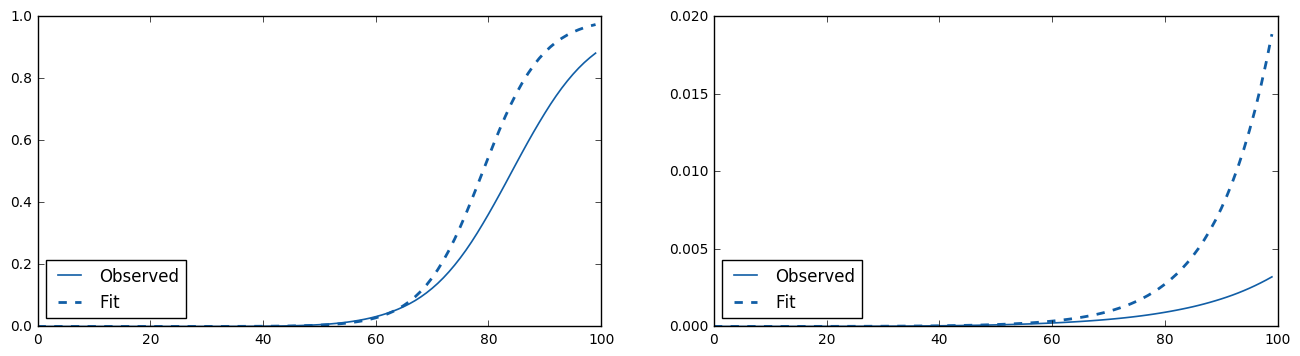

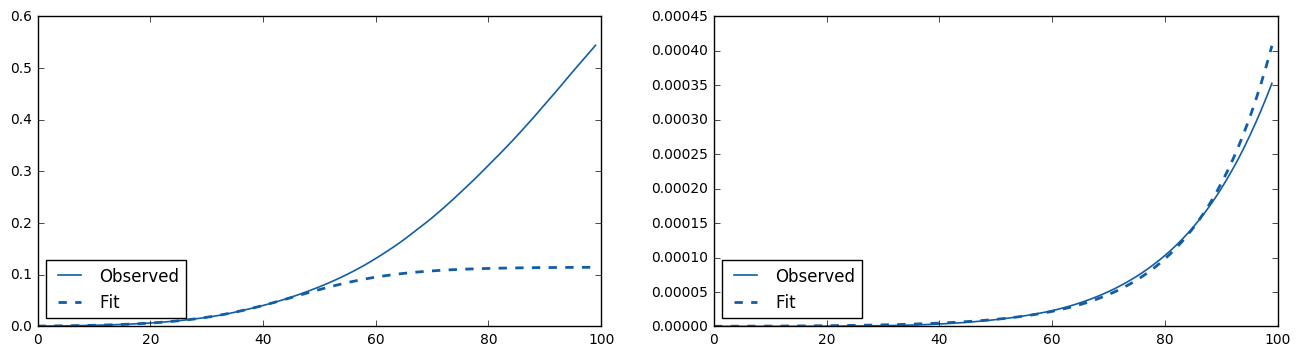

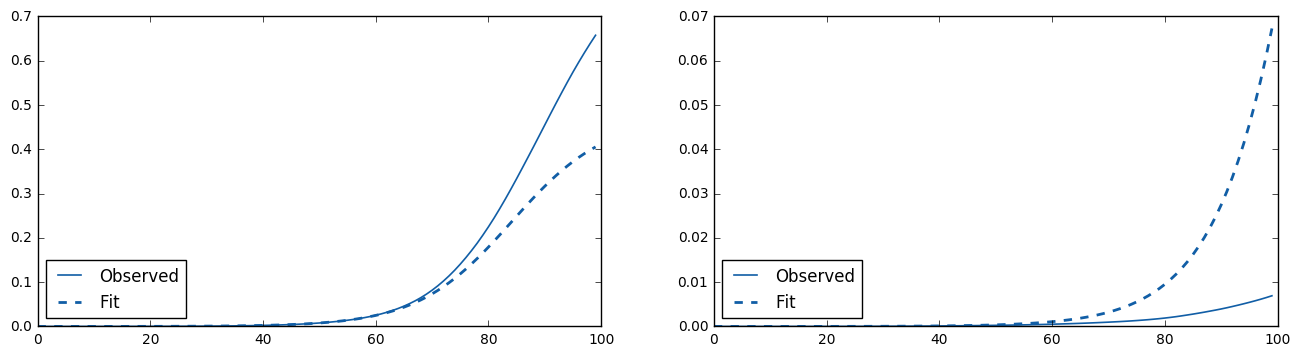

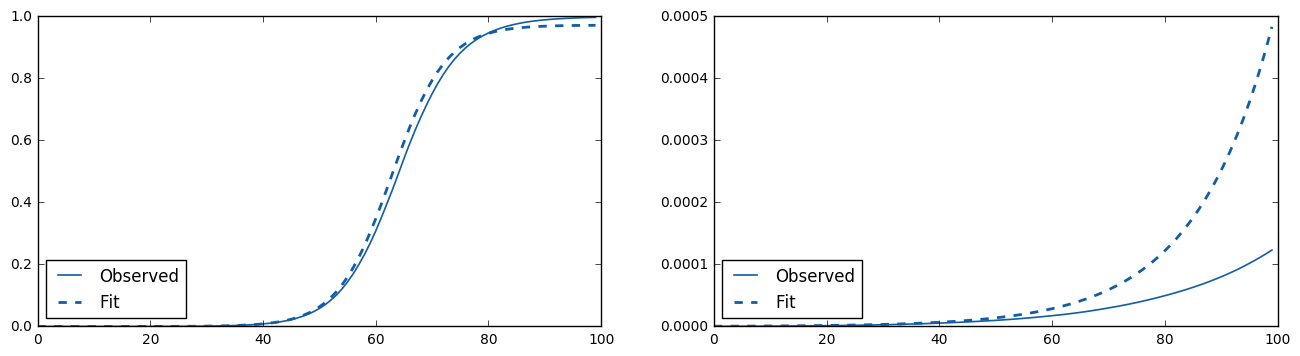

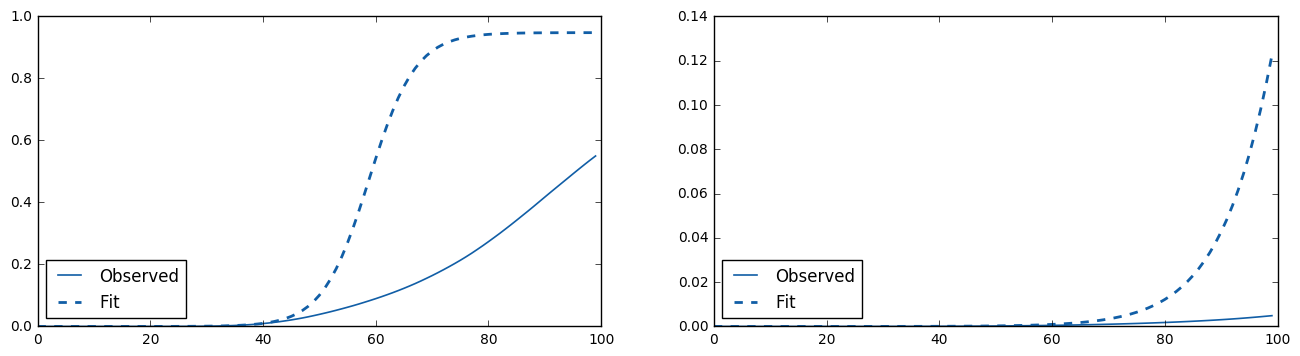

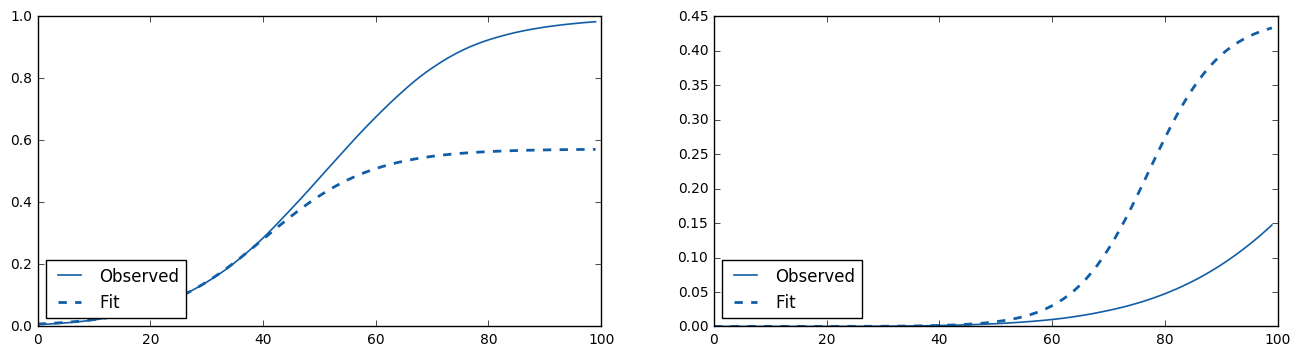

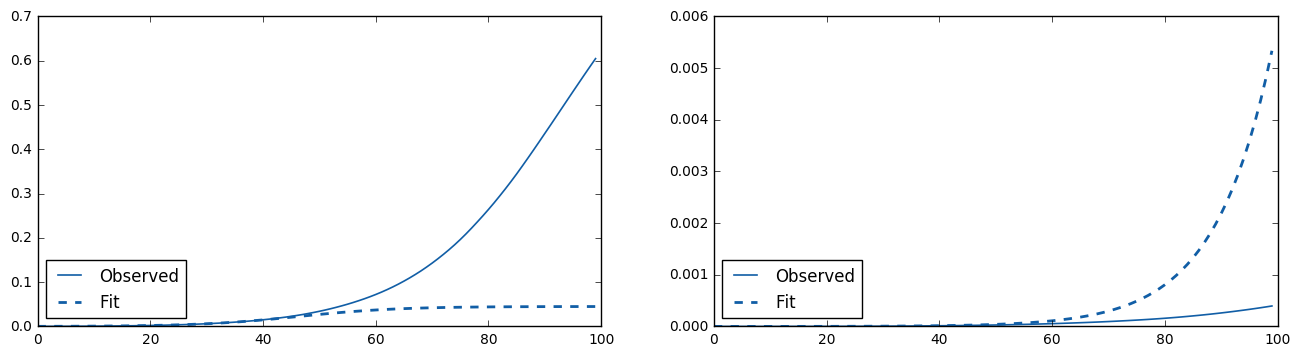

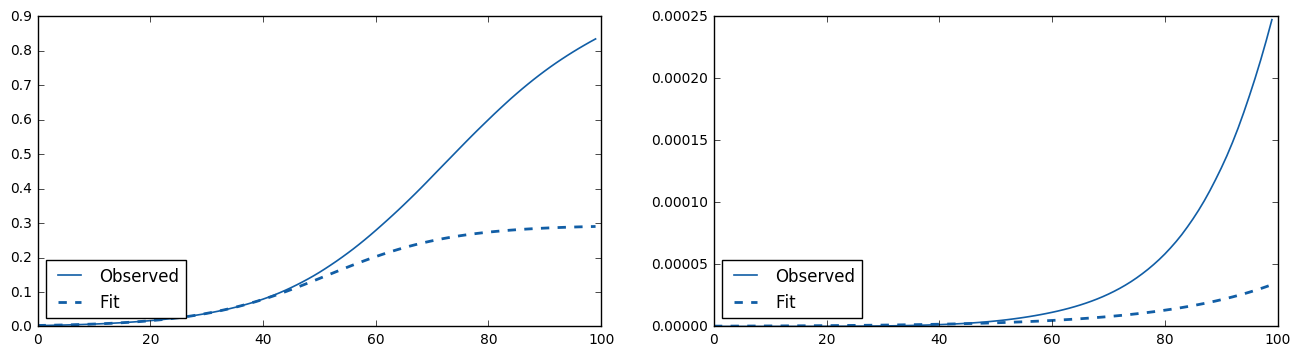

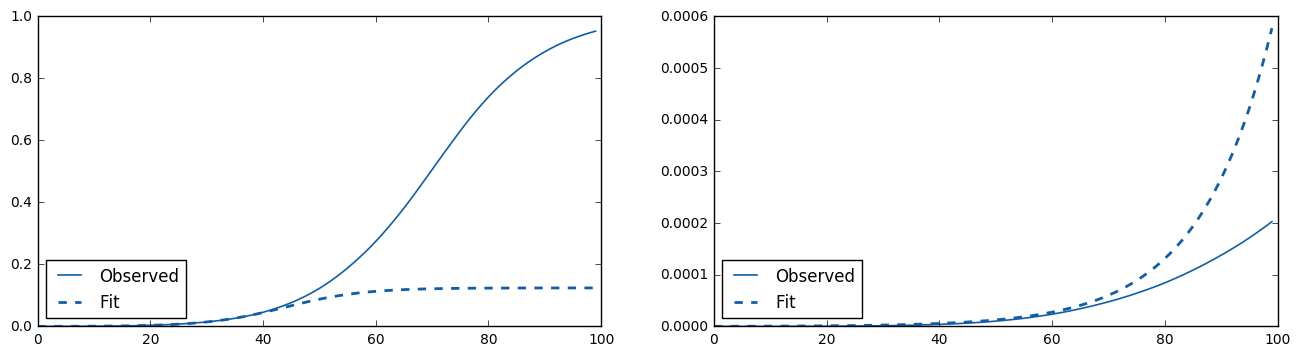

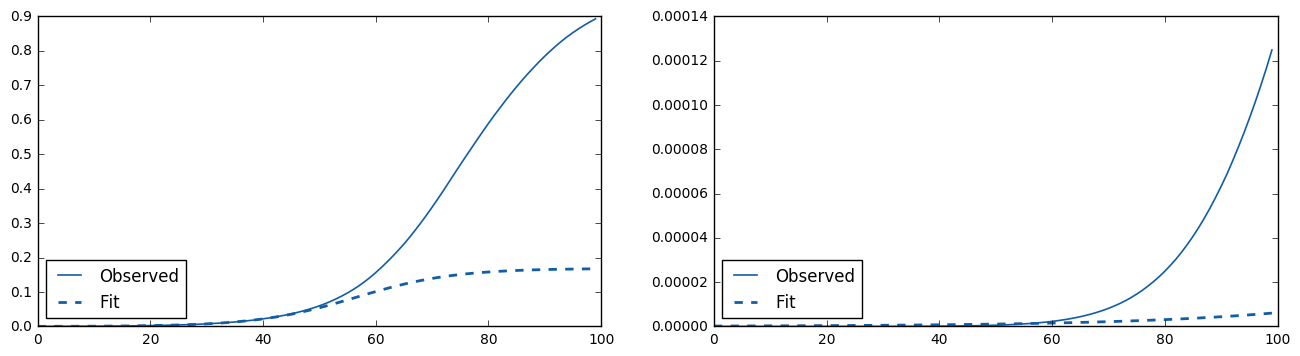

In [18]:
successful_curves = curves[curves[:,-1] >= 0.5, :]
successful_predictions = predictions[curves[:,-1] >= 0.5, :]

failed_curves = curves[curves[:,-1] < 0.2, :]
failed_predictions = predictions[curves[:,-1] < 0.2, :]

for i in range(10, 20):
    fig, (ax0, ax1) = ppt.subplots(ncols=2, figsize=(16, 4))
    ax0.plot(successful_curves[i], label='Observed', color='#115EA6', linewidth=1.2, linestyle='-')
    ax0.plot(successful_predictions[i], label='Fit', color='#115EA6', linewidth=2, linestyle='--')
    ax0.legend(loc='lower left')

    ax1.plot(failed_curves[i], label='Observed', color='#115EA6', linewidth=1.2, linestyle='-')
    ax1.plot(failed_predictions[i], label='Fit', color='#115EA6', linewidth=2, linestyle='--')
    ax1.legend(loc='lower left')

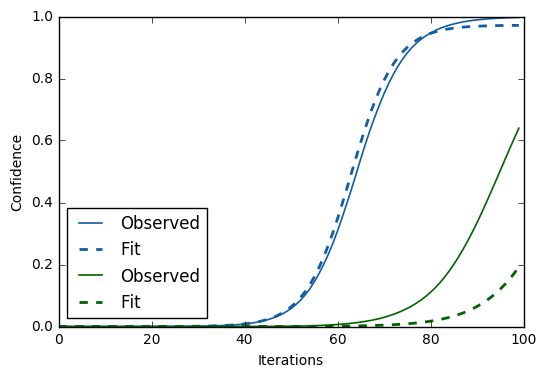

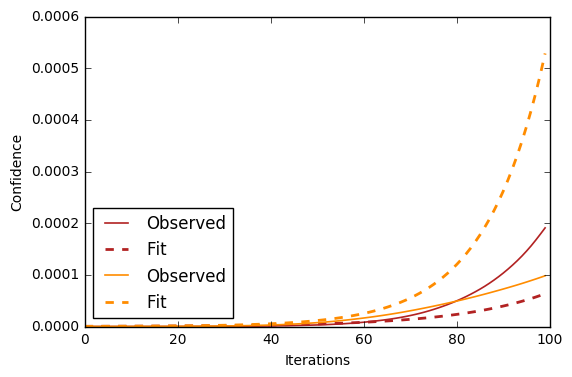

In [19]:
def plot(curves, predictions, colors):
    fig = ppt.figure()
    for cu, pr, co in zip(curves, predictions, colors):
        ppt.plot(cu, label='Observed', color=co, linewidth=1.2, linestyle='-')
        ppt.plot(pr, label='Fit', color=co, linewidth=2, linestyle='--')
        ppt.xlabel('Iterations')
        ppt.ylabel('Confidence')
        ppt.legend(loc='lower left')
    return fig

success_colors = ('#115EA6', 'darkgreen')
success_indices = (13, 5)
fig = plot(successful_curves[success_indices,:], successful_predictions[success_indices,:], success_colors)
fig.savefig(SAVE_PATH_PREFIX + '-success.png', bbox_inches='tight')

failure_colors = ('firebrick', 'darkorange', 'mediumorchid')
failure_indices = (2, 7)
fig = plot(failed_curves[failure_indices,:], failed_predictions[failure_indices,:], failure_colors)
fig.savefig(SAVE_PATH_PREFIX + '-failure.png', bbox_inches='tight')